# 003_eda

In [7]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm


In [8]:
# 試験ID生成
trial_prefix = 'nb003'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb003
nb003_20210522_162508


In [9]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [10]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [11]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [12]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [14]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [15]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [17]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## テキスト特徴_TF-IDF

In [67]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, input_df, _master_df=None, y=None, n_components=50, ngram_range=(1,1)):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000)),
            ('svd', TruncatedSVD(n_components=n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')


In [68]:
block = TfidfBlock('excerpt')

In [69]:
block.fit(train_base, train_base)

,excerpt_tfidf_0,excerpt_tfidf_1,excerpt_tfidf_2,excerpt_tfidf_3,excerpt_tfidf_4,excerpt_tfidf_5,excerpt_tfidf_6,excerpt_tfidf_7,excerpt_tfidf_8,excerpt_tfidf_9,...,excerpt_tfidf_40,excerpt_tfidf_41,excerpt_tfidf_42,excerpt_tfidf_43,excerpt_tfidf_44,excerpt_tfidf_45,excerpt_tfidf_46,excerpt_tfidf_47,excerpt_tfidf_48,excerpt_tfidf_49
0,0.123560,0.018494,-0.017181,0.030045,-0.054988,-0.000772,-0.028780,-0.015365,-0.032837,-0.004917,...,-0.023847,0.083818,-0.012007,-0.001356,0.002260,-0.009950,-0.037473,0.013455,-0.046709,-0.001283
1,0.137494,-0.061238,0.030682,-0.040259,0.048555,-0.054909,0.056760,0.006588,0.040611,-0.038065,...,-0.007098,0.064584,-0.001586,-0.015189,-0.034618,0.000309,-0.006847,-0.060326,0.002993,-0.047075
2,0.106329,-0.031446,0.010140,-0.007324,-0.008595,-0.006286,0.012553,-0.002404,0.002155,-0.014096,...,0.026316,0.023622,0.036075,0.018103,-0.068129,0.003476,0.038298,0.011090,-0.033483,0.012033
3,0.110198,-0.033884,-0.023035,0.058395,-0.043022,0.073976,-0.044271,-0.021103,-0.027616,0.019723,...,-0.061631,0.062323,-0.021104,-0.017099,-0.023008,-0.014528,-0.033633,-0.030392,0.013115,0.059860
4,0.118571,-0.056268,-0.001577,0.012658,-0.020762,0.049253,0.013889,-0.022362,-0.048006,-0.010330,...,0.139579,0.170488,-0.005847,-0.033382,-0.040378,-0.008033,0.094335,-0.053574,0.029472,-0.081564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0.099917,0.039966,-0.000333,0.011431,0.024682,0.023292,-0.057984,-0.030440,0.013989,-0.023865,...,0.013467,-0.031618,0.007103,-0.029652,0.010596,-0.007566,0.008383,0.056845,-0.018251,0.001395
2830,0.097239,0.073228,0.036358,0.081767,0.017501,-0.026963,0.027659,-0.016273,0.026375,0.003259,...,0.059905,0.037791,0.041646,-0.022746,0.081938,0.016579,-0.021529,-0.016821,0.062461,0.034535
2831,0.079075,0.090589,-0.001879,0.131906,0.009020,-0.001041,0.098732,0.067908,0.044721,-0.053407,...,0.059674,0.022993,0.011343,0.016548,0.049502,0.016459,0.013493,0.042608,-0.023814,0.030277
2832,0.085418,0.073021,0.016011,0.043716,-0.001690,-0.018604,0.019094,-0.015897,-0.002246,-0.012321,...,0.031093,0.010491,0.004356,-0.032724,0.009662,0.025866,0.064417,-0.004165,-0.012351,0.028681


In [70]:
whole_df = pd.concat([train_base.drop(['target', 'standard_error'], axis='columns'), test_base], axis='rows')

In [71]:
block.fit(train_base, whole_df)

,excerpt_tfidf_0,excerpt_tfidf_1,excerpt_tfidf_2,excerpt_tfidf_3,excerpt_tfidf_4,excerpt_tfidf_5,excerpt_tfidf_6,excerpt_tfidf_7,excerpt_tfidf_8,excerpt_tfidf_9,...,excerpt_tfidf_40,excerpt_tfidf_41,excerpt_tfidf_42,excerpt_tfidf_43,excerpt_tfidf_44,excerpt_tfidf_45,excerpt_tfidf_46,excerpt_tfidf_47,excerpt_tfidf_48,excerpt_tfidf_49
0,0.123549,0.018368,-0.017191,0.030062,-0.055448,-0.000674,-0.028631,-0.016800,-0.030319,-0.007267,...,-0.027707,0.084165,-0.010422,0.003400,0.016006,-0.013658,-0.027713,-0.010373,-0.022146,0.056856
1,0.137946,-0.061447,0.031020,-0.040993,0.048693,-0.055729,0.056470,0.009198,0.039012,-0.031965,...,-0.013865,0.070780,0.003334,-0.013899,-0.021043,-0.014639,0.028679,-0.067053,0.005993,0.021449
2,0.106283,-0.031343,0.010265,-0.007268,-0.008628,-0.006622,0.012452,-0.002258,0.004076,-0.014338,...,0.014822,0.028942,0.034861,0.019182,-0.061760,-0.015775,0.029469,0.028632,-0.035377,0.006294
3,0.110189,-0.033721,-0.022660,0.058419,-0.042771,0.073800,-0.044020,-0.022216,-0.027000,0.018090,...,-0.069671,0.056646,-0.014804,-0.017481,0.000365,-0.030131,-0.016103,-0.046300,-0.007970,-0.038773
4,0.118466,-0.056116,-0.001316,0.012712,-0.020462,0.049868,0.014362,-0.022955,-0.045457,-0.010891,...,0.131670,0.179213,-0.009361,-0.032329,-0.022700,-0.015752,0.111633,-0.018730,0.027228,0.028865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0.099802,0.040010,-0.000535,0.011430,0.024984,0.023352,-0.058177,-0.030481,0.016261,-0.022678,...,0.008305,-0.030905,0.003723,-0.028906,0.004556,-0.002237,-0.018229,0.062554,-0.005855,0.012209
2830,0.097176,0.073269,0.036086,0.081496,0.017796,-0.027037,0.027482,-0.014741,0.026950,0.005633,...,0.059359,0.042134,0.038740,-0.036009,0.062438,0.049582,-0.026260,-0.020964,0.043489,-0.040517
2831,0.078963,0.090593,-0.002193,0.131816,0.009275,-0.001430,0.097414,0.069591,0.045058,-0.052890,...,0.062405,0.028365,0.007133,0.015939,0.031143,0.035508,-0.005151,0.047156,-0.012515,0.012304
2832,0.085321,0.073047,0.015815,0.043615,-0.001450,-0.018495,0.018986,-0.015460,0.000081,-0.011861,...,0.021866,0.015742,-0.001806,-0.035048,-0.002988,0.039371,0.041489,0.035667,-0.032464,-0.030688


In [72]:
block.fit(train_base, train_base)

,excerpt_tfidf_0,excerpt_tfidf_1,excerpt_tfidf_2,excerpt_tfidf_3,excerpt_tfidf_4,excerpt_tfidf_5,excerpt_tfidf_6,excerpt_tfidf_7,excerpt_tfidf_8,excerpt_tfidf_9,...,excerpt_tfidf_40,excerpt_tfidf_41,excerpt_tfidf_42,excerpt_tfidf_43,excerpt_tfidf_44,excerpt_tfidf_45,excerpt_tfidf_46,excerpt_tfidf_47,excerpt_tfidf_48,excerpt_tfidf_49
0,0.123560,0.018494,-0.017181,0.030045,-0.054988,-0.000772,-0.028780,-0.015365,-0.032837,-0.004917,...,-0.023847,0.083818,-0.012007,-0.001356,0.002260,-0.009950,-0.037473,0.013455,-0.046709,-0.001283
1,0.137494,-0.061238,0.030682,-0.040259,0.048555,-0.054909,0.056760,0.006588,0.040611,-0.038065,...,-0.007098,0.064584,-0.001586,-0.015189,-0.034618,0.000309,-0.006847,-0.060326,0.002993,-0.047075
2,0.106329,-0.031446,0.010140,-0.007324,-0.008595,-0.006286,0.012553,-0.002404,0.002155,-0.014096,...,0.026316,0.023622,0.036075,0.018103,-0.068129,0.003476,0.038298,0.011090,-0.033483,0.012033
3,0.110198,-0.033884,-0.023035,0.058395,-0.043022,0.073976,-0.044271,-0.021103,-0.027616,0.019723,...,-0.061631,0.062323,-0.021104,-0.017099,-0.023008,-0.014528,-0.033633,-0.030392,0.013115,0.059860
4,0.118571,-0.056268,-0.001577,0.012658,-0.020762,0.049253,0.013889,-0.022362,-0.048006,-0.010330,...,0.139579,0.170488,-0.005847,-0.033382,-0.040378,-0.008033,0.094335,-0.053574,0.029472,-0.081564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0.099917,0.039966,-0.000333,0.011431,0.024682,0.023292,-0.057984,-0.030440,0.013989,-0.023865,...,0.013467,-0.031618,0.007103,-0.029652,0.010596,-0.007566,0.008383,0.056845,-0.018251,0.001395
2830,0.097239,0.073228,0.036358,0.081767,0.017501,-0.026963,0.027659,-0.016273,0.026375,0.003259,...,0.059905,0.037791,0.041646,-0.022746,0.081938,0.016579,-0.021529,-0.016821,0.062461,0.034535
2831,0.079075,0.090589,-0.001879,0.131906,0.009020,-0.001041,0.098732,0.067908,0.044721,-0.053407,...,0.059674,0.022993,0.011343,0.016548,0.049502,0.016459,0.013493,0.042608,-0.023814,0.030277
2832,0.085418,0.073021,0.016011,0.043716,-0.001690,-0.018604,0.019094,-0.015897,-0.002246,-0.012321,...,0.031093,0.010491,0.004356,-0.032724,0.009662,0.025866,0.064417,-0.004165,-0.012351,0.028681


### 可視化

In [127]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_{"_".join([str(i) for i in self.ngram_range])}_')


In [128]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [129]:
def tsne_run_and_show(z):
    tsne = TSNE(n_jobs=-1)
    embedding = tsne.fit_transform(z)

    bin_labels = pd.cut(train_base['target'], bins=5)
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(*embedding.T, c=bin_labels.cat.codes, s=20, alpha=.8, cmap='cividis')
    ax.grid()

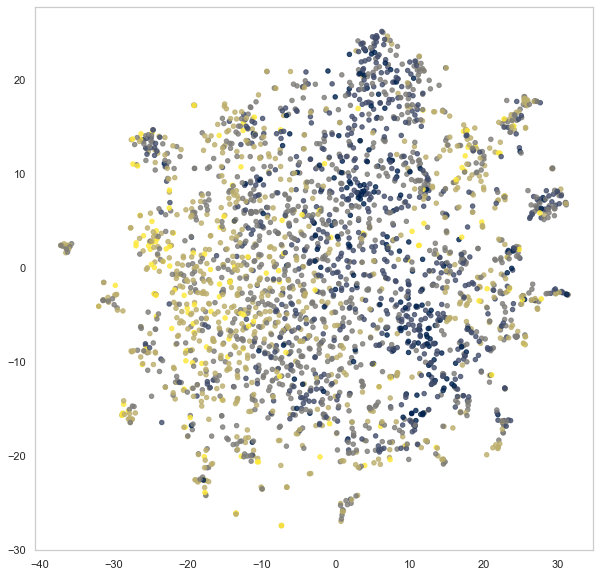

In [130]:
block = TfidfBlock('excerpt')
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

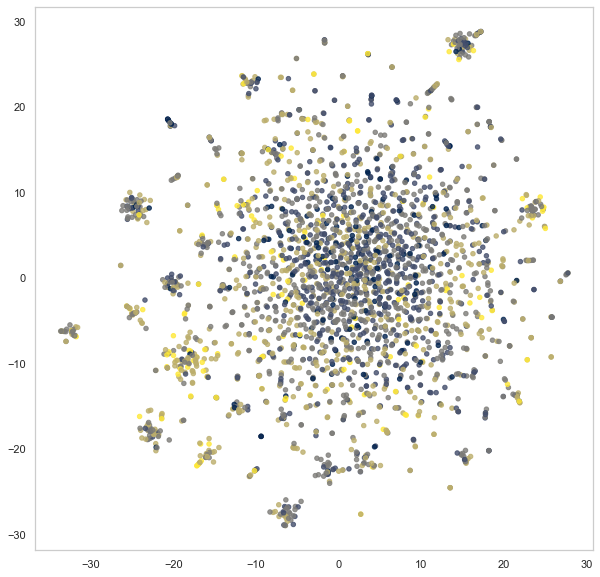

In [131]:
block = TfidfBlock('excerpt', ngram_range=(2,2))
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

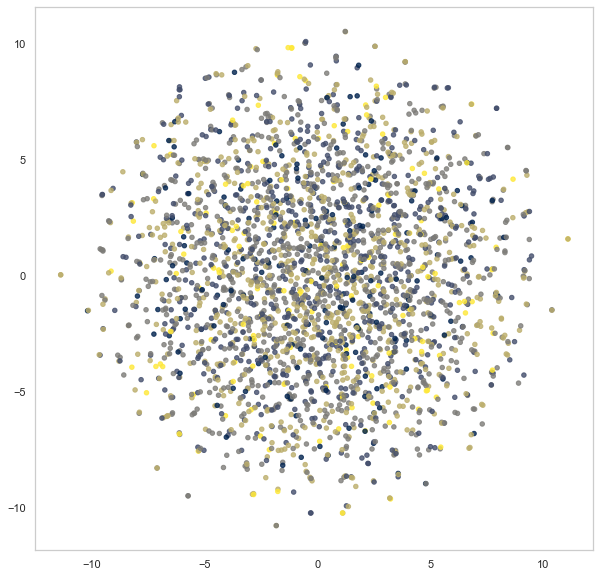

In [132]:
block = TfidfBlock('excerpt', ngram_range=(5,5))
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

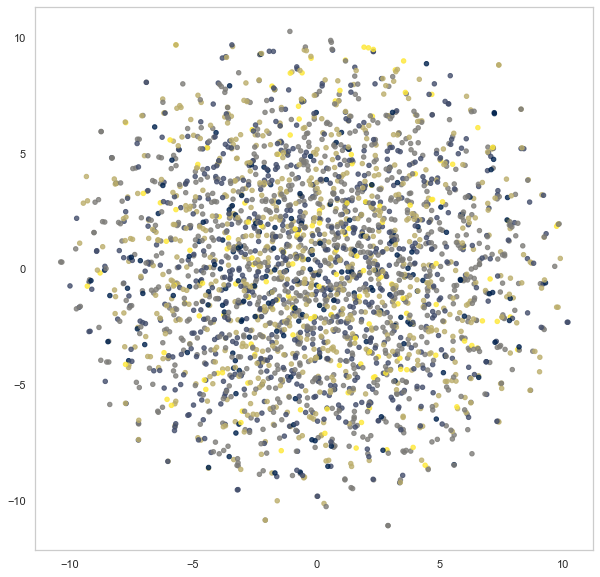

In [133]:
block = TfidfBlock('excerpt', ngram_range=(10,10))
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

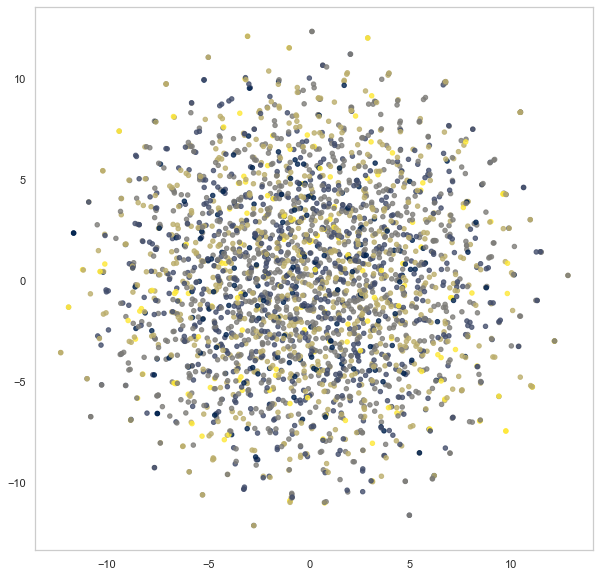

In [134]:
block = TfidfBlock('excerpt', ngram_range=(3,3))
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

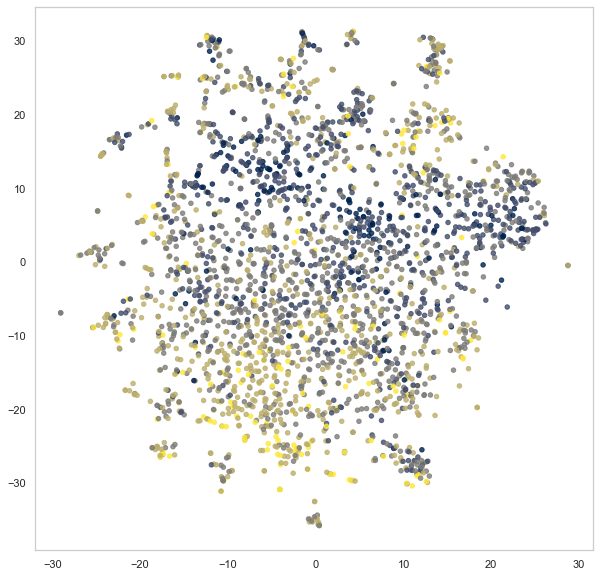

In [135]:
block = TfidfBlock('excerpt', ngram_range=(1,2))
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

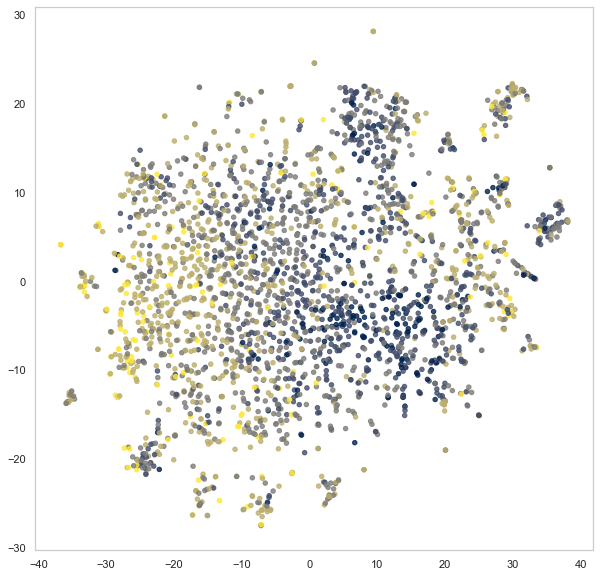

In [136]:
block = TfidfBlock('excerpt', ngram_range=(1,3))
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

- unigram, bigramまでなら、比較的特徴は分割される。
- trigram以上になると、特徴が無くなってしまう。
- (1,1),(1,2),(2,2)で特徴を作ってみよう。

# make_feat

In [146]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = train_base.copy() # あとで、「test_featをconcatしたver」も試す。

In [147]:
# block初期化
tfidf_uni = TfidfBlock('excerpt', ngram_range=(1,1))
tfidf_bi = TfidfBlock('excerpt', ngram_range=(2,2))
tfidf_uni_bi = TfidfBlock('excerpt', ngram_range=(1,2))

In [148]:
# fit & trainの特徴作成
train_feat = pd.concat([train_feat, tfidf_uni.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_bi.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_uni_bi.fit(train_base, whole_df)], axis='columns')

In [149]:
# testの特徴作成
test_feat = pd.concat([test_feat, tfidf_uni.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_bi.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_uni_bi.transform(test_base)], axis='columns')

In [150]:
print(train_feat.shape)
train_feat.head()

(2834, 150)


,excerpt_tfidf_1_1_0,excerpt_tfidf_1_1_1,excerpt_tfidf_1_1_2,excerpt_tfidf_1_1_3,excerpt_tfidf_1_1_4,excerpt_tfidf_1_1_5,excerpt_tfidf_1_1_6,excerpt_tfidf_1_1_7,excerpt_tfidf_1_1_8,excerpt_tfidf_1_1_9,...,excerpt_tfidf_1_2_40,excerpt_tfidf_1_2_41,excerpt_tfidf_1_2_42,excerpt_tfidf_1_2_43,excerpt_tfidf_1_2_44,excerpt_tfidf_1_2_45,excerpt_tfidf_1_2_46,excerpt_tfidf_1_2_47,excerpt_tfidf_1_2_48,excerpt_tfidf_1_2_49
0,0.123560,0.018494,-0.017181,0.030045,-0.054988,-0.000772,-0.028780,-0.015365,-0.032837,-0.004917,...,-0.032440,0.049316,-0.012754,0.027896,0.000142,0.013143,-0.011394,-0.012110,-0.063936,0.008975
1,0.137494,-0.061238,0.030682,-0.040259,0.048555,-0.054909,0.056760,0.006588,0.040611,-0.038065,...,-0.022481,0.024045,-0.015550,0.018315,-0.029293,-0.023724,-0.001448,-0.007430,0.018735,-0.046819
2,0.106329,-0.031446,0.010140,-0.007324,-0.008595,-0.006286,0.012553,-0.002404,0.002155,-0.014096,...,-0.006992,0.005294,-0.038128,-0.015859,-0.045104,0.026987,0.033355,-0.003255,0.011393,0.012657
3,0.110198,-0.033884,-0.023035,0.058395,-0.043022,0.073976,-0.044271,-0.021103,-0.027616,0.019723,...,-0.041328,0.011631,-0.014809,0.025734,-0.009518,-0.021125,-0.039716,0.004215,-0.059669,0.003051
4,0.118571,-0.056268,-0.001577,0.012658,-0.020762,0.049253,0.013889,-0.022362,-0.048006,-0.010330,...,0.008544,0.119364,-0.055591,0.005356,-0.034509,-0.024195,0.077441,0.035213,0.035054,-0.009790


In [151]:
print(test_feat.shape)
test_feat.head()

(7, 150)


,excerpt_tfidf_1_1_0,excerpt_tfidf_1_1_1,excerpt_tfidf_1_1_2,excerpt_tfidf_1_1_3,excerpt_tfidf_1_1_4,excerpt_tfidf_1_1_5,excerpt_tfidf_1_1_6,excerpt_tfidf_1_1_7,excerpt_tfidf_1_1_8,excerpt_tfidf_1_1_9,...,excerpt_tfidf_1_2_40,excerpt_tfidf_1_2_41,excerpt_tfidf_1_2_42,excerpt_tfidf_1_2_43,excerpt_tfidf_1_2_44,excerpt_tfidf_1_2_45,excerpt_tfidf_1_2_46,excerpt_tfidf_1_2_47,excerpt_tfidf_1_2_48,excerpt_tfidf_1_2_49
0,0.161546,-0.003871,-0.028012,0.021961,-0.018859,-0.029275,0.012851,0.056964,0.030662,0.020336,...,-0.010882,-0.021878,-0.006506,-0.026149,-0.010434,-0.005265,0.008528,-0.019894,-0.017166,-0.004479
1,0.204259,-0.064879,0.001639,-0.060913,0.044344,-0.014828,-0.008934,0.054799,0.056839,0.068055,...,-0.021183,-0.004822,-0.028914,0.021178,-0.010403,-0.030961,0.004069,-0.017070,-0.005123,-0.040826
2,0.127225,-0.057817,-0.003748,-0.017756,-0.038171,-0.032543,0.002004,-0.010475,-0.007703,-0.014267,...,0.010403,-0.003209,0.009801,0.039010,-0.005443,-0.002452,-0.006727,0.005102,-0.005535,0.008362
3,0.057296,0.100420,0.075907,0.015936,-0.019845,-0.001749,0.011321,-0.019968,-0.100330,0.044088,...,-0.025934,0.004836,0.014417,0.050418,0.012811,0.001609,-0.009619,0.020148,0.002790,-0.002250
4,0.058965,0.101686,0.010253,-0.004939,0.003997,-0.065291,0.027663,-0.099940,0.021398,0.045877,...,-0.032583,0.009019,-0.002070,0.001647,0.010034,0.010449,0.008699,-0.004879,0.008197,0.012208


In [152]:
print(train_feat.shape)
print(test_feat.shape)

(2834, 150)
(7, 150)


# train & predict

In [153]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [154]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [155]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [156]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [157]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 150
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.362607	valid's rmse: 0.770707
Early stopping, best iteration is:
[60]	training's rmse: 0.318332	valid's rmse: 0.766303

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 150
[LightGBM] [Info] Start training from score -0.946950
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.3

In [158]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [159]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-1.032481
1,f0953f0a5,-0.323063
2,0df072751,-0.764551
3,04caf4e0c,-1.614717
4,0e63f8bea,-1.779661


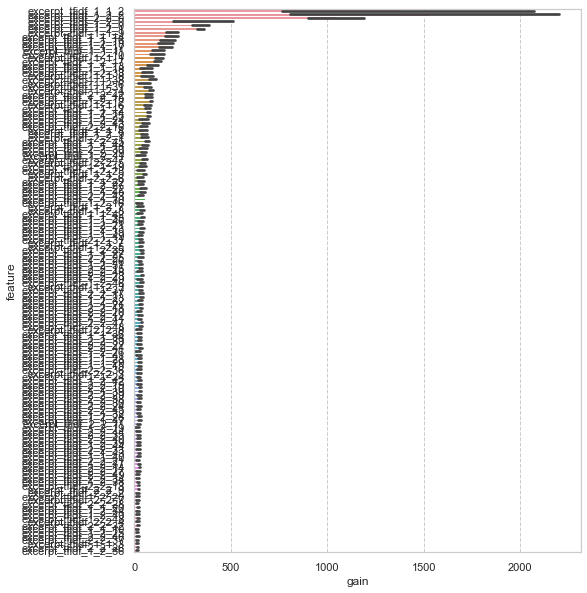

In [160]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

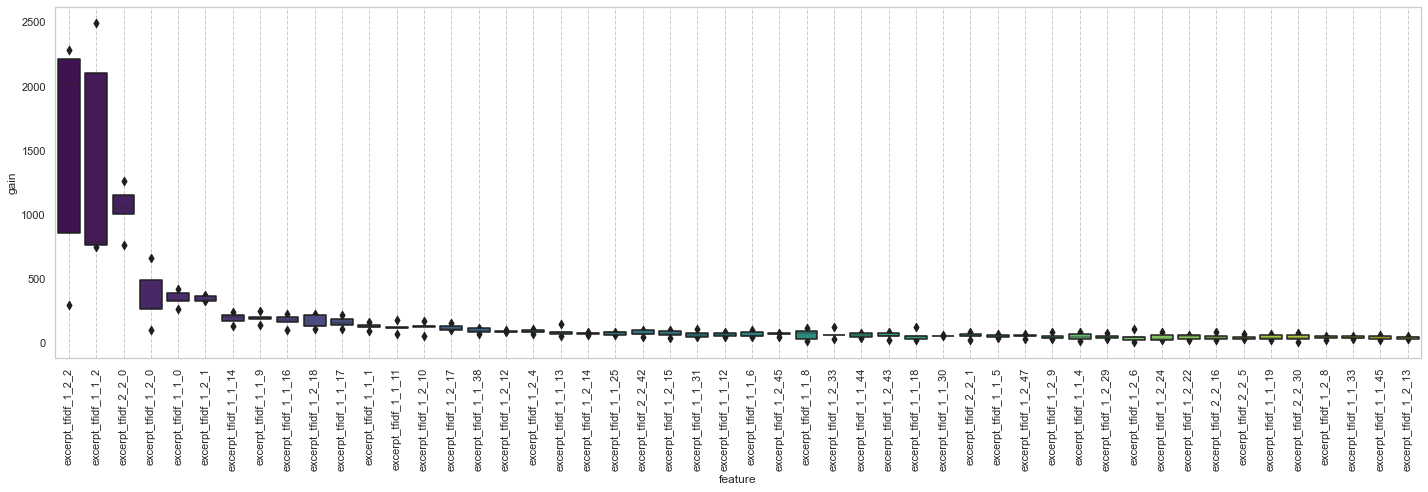

In [161]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [162]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

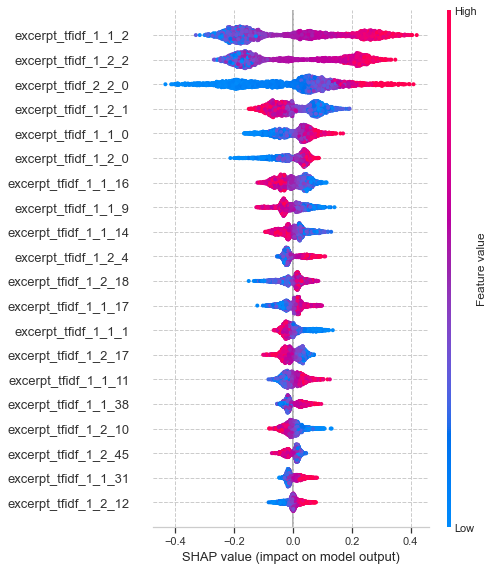

In [163]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

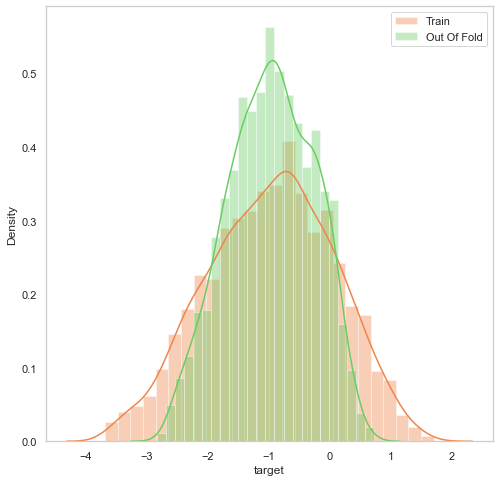

In [164]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))